<a href="https://colab.research.google.com/github/hoangcuongnguyen2001/Stocks-Analysis/blob/main/Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setting up the environment**

First we will need to install the yfinance library from Python, for crawling data from Yahoo Finance:

In [2]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

Then we will import this library and NumPy for data wrangling:

In [3]:
import yfinance as yf
import numpy as np


**Upload financial data**

We will upload the data from 4 tickers for shares and ETFs: TSLA (for Tesla), AAPL (for Apple), SPY (for SPDR S&P 500 ETF Trust, as approximation for S&P 500), and QQQ (Invesco QQQ Trust Series 1, as approximation for NASDAQ).

In [4]:
symbols = ['TSLA', 'AAPL', 'SPY', 'QQQ']

Then we will setup the time for the past 5 years (this will automatically set up the date).

In [5]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

five_yrs_ago = datetime.now() - relativedelta(years=5)



data = yf.download(symbols, five_yrs_ago)['Adj Close']

[*********************100%***********************]  4 of 4 completed


The price data for 5 years ago are printed here.

In [6]:
print(data)

                  AAPL         QQQ         SPY        TSLA
Date                                                      
2018-03-05   42.141560  162.147202  249.906677   22.223333
2018-03-06   42.105801  162.833176  250.540115   21.879999
2018-03-07   41.714943  163.209961  250.448318   22.153334
2018-03-08   42.170166  164.108490  251.660248   21.940001
2018-03-09   42.894684  167.296722  256.039795   21.811333
...                ...         ...         ...         ...
2023-02-27  147.919998  293.940002  397.730011  207.630005
2023-02-28  147.410004  293.559998  396.260010  205.710007
2023-03-01  145.309998  291.200012  394.739990  202.770004
2023-03-02  145.910004  293.609985  397.809998  190.899994
2023-03-03  151.029999  299.679993  404.190002  197.789993

[1259 rows x 4 columns]


Then we will calculate the cumulative return (based on adjusted close price, since that price has already accounted for dividends, stock split, etc.)

In [7]:
price_change = data.pct_change()
price_change['TSLA_net_position'] = price_change.TSLA.cumsum().shift().fillna(0)
price_change['AAPL_net_position'] = price_change.AAPL.cumsum().shift().fillna(0)
price_change['SPY_net_position'] = price_change.SPY.cumsum().shift().fillna(0)
price_change['QQQ_net_position'] = price_change.QQQ.cumsum().shift().fillna(0)

price_change['SPY_fixed'] = 100 + price_change['SPY_net_position'] * 100
price_change['TSLA_fixed'] = 100 + price_change['TSLA_net_position'] * 100
price_change['AAPL_fixed'] = 100 + price_change['AAPL_net_position'] * 100
price_change['QQQ_fixed'] = 100 + price_change['QQQ_net_position'] * 100

print(price_change) 

                AAPL       QQQ       SPY      TSLA  TSLA_net_position  \
Date                                                                    
2018-03-05       NaN       NaN       NaN       NaN           0.000000   
2018-03-06 -0.000849  0.004231  0.002535 -0.015449           0.000000   
2018-03-07 -0.009283  0.002314 -0.000366  0.012492          -0.015449   
2018-03-08  0.010913  0.005505  0.004839 -0.009630          -0.002957   
2018-03-09  0.017181  0.019428  0.017403 -0.005865          -0.012587   
...              ...       ...       ...       ...                ...   
2023-02-27  0.008248  0.007161  0.003406  0.054602           3.284059   
2023-02-28 -0.003448 -0.001293 -0.003696 -0.009247           3.338660   
2023-03-01 -0.014246 -0.008039 -0.003836 -0.014292           3.329413   
2023-03-02  0.004129  0.008276  0.007777 -0.058539           3.315121   
2023-03-03  0.035090  0.020674  0.016038  0.036092           3.256582   

            AAPL_net_position  SPY_net_position  Q

After that, we will draw a graph to compare the cumulative return of Apple and Tesla with S&P500 and NASDAQ. Here we will set the initial price (5 years ago) as 100 for consistency.

In [8]:
df = price_change.drop(price_change.index[0])

In [9]:
def cm_to_inch(value):
    return value/2.54


import matplotlib.pyplot as plt
import matplotlib.dates as mdates



plt.figure(figsize=(cm_to_inch(50), cm_to_inch(20)))
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter(x=df.index,y=df['TSLA_fixed'], mode='lines', name='Tesla'))
fig.add_trace(go.Scatter(x=df.index, y=df['AAPL_fixed'],mode='lines',
                    name='Apple'))
fig.add_trace(go.Scatter(x=df.index, y=df['SPY_fixed'],mode='lines',
                    name='S&P 500'))
fig.add_trace(go.Scatter(x=df.index, y=df['QQQ_fixed'],mode='lines',
                    name='Nasdaq'))
fig.update_layout(title='Comparison of price return between S&P 500, Apple and Tesla in 1 year',
                   xaxis_title='Month',
                   yaxis_title='Price index (2017 = 100)')
fig.show()

<Figure size 1417.32x566.929 with 0 Axes>

Finally we will compare the change in price per day between Tesla, Apple and S&P500 with a scatter chart (the further the dots are with the 0 line, the more volatile the stock is). As seen in this graph, Tesla is much more volatile compared to Apple and S&P500.

In [10]:
plt.figure(figsize=(cm_to_inch(50), cm_to_inch(20)))

fig = go.Figure(data=go.Scatter(x=df.index,y=df['TSLA'], mode='markers', name='Tesla'))
fig.add_trace(go.Scatter(x=df.index, y=df['SPY'],mode='markers',
                    name='S&P 500'))
fig.add_trace(go.Scatter(x=df.index, y=df['AAPL'],mode='markers',
                    name='Apple'))
fig.update_layout(title='Comparison of price change per day between S&P 500, Apple and Tesla in 1 years',
                   xaxis_title='Month',
                   yaxis_title='Price change per day')
fig.show()

<Figure size 1417.32x566.929 with 0 Axes>

**Beta Calculation**

We could calculate beta of Tesla and Apple by calculating the covariance of each stock with the whole market (in this case, S&P500 is used as proxy). Then the covariance would be divided by variance of the S&P500 index in 5 years.

In [11]:
def covariance(x, y):
    # Finding the mean of the series x and y
    mean_x = sum(x)/float(len(x))
    mean_y = sum(y)/float(len(y))
    # Subtracting mean from the individual elements
    sub_x = [i - mean_x for i in x]
    sub_y = [i - mean_y for i in y]
    numerator = sum([sub_x[i]*sub_y[i] for i in range(len(sub_x))])
    denominator = len(x)-1
    cov = numerator/denominator
    return cov


covar_TSLA = covariance(df.TSLA, df.SPY)
covar_AAPL = covariance(df.AAPL, df.SPY)
variance = np.var(df.SPY)
beta_TSLA = round(covar_TSLA/variance,4)
beta_AAPL = round(covar_AAPL/variance,4)

In [12]:
print('Beta for Tesla: ', beta_TSLA)
print('Beta for Apple: ', beta_AAPL)

Beta for Tesla:  1.4858
Beta for Apple:  1.2549


**Portfolio Optimization** (Note: This code is taken from https://github.com/egarcia00/Portfolio_Optimization_Medium (from Eduardo Garcia's article in Medium: https://medium.com/@eduardo.garcia.sv/if-you-dont-have-any-idea-how-to-create-a-stock-portfolio-this-will-help-you-99efc92cd4d5)

We will need to set up Download function for multiple assets first (This would be a new function for later tasks)

In [18]:
#Download multiple assets history
def download(tickers, start=None, end=None, actions=False, threads=True,
             group_by='column', auto_adjust=False, back_adjust=False,
             progress=True, period="max", show_errors=True, interval="1d", prepost=False,
             proxy=None, rounding=False, timeout=None, **kwargs):
    """Download yahoo tickers
    :Parameters:
        tickers : str, list
            List of tickers to download
        period : str
            Valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
            Either Use period parameter or use start and end
        interval : str
            Valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
            Intraday data cannot extend last 60 days
        start: str
            Download start date string (YYYY-MM-DD) or _datetime.
            Default is 1900-01-01
        end: str
            Download end date string (YYYY-MM-DD) or _datetime.
            Default is now
        group_by : str
            Group by 'ticker' or 'column' (default)
        prepost : bool
            Include Pre and Post market data in results?
            Default is False
        auto_adjust: bool
            Adjust all OHLC automatically? Default is False
        actions: bool
            Download dividend + stock splits data. Default is False
        threads: bool / int
            How many threads to use for mass downloading. Default is True
        proxy: str
            Optional. Proxy server URL scheme. Default is None
        rounding: bool
            Optional. Round values to 2 decimal places?
        show_errors: bool
            Optional. Doesn't print errors if True
        timeout: None or float
            If not None stops waiting for a response after given number of
            seconds. (Can also be a fraction of a second e.g. 0.01)
    """

Then we will add a benchmark (Nasdaq in this case for Tesla and Apple, since the index is tech heavy and therefore more suitable for the program though!)


In [28]:
benchmark_ = ["QQQ",]
portfolio_ = ['AAPL',  'TSLA']
#Note: You could try the benchmark with SPY to see what happen. For other indices, please find the appropriate ETF as benchmark, like IOZ 
#for ASX200 (the main Australian stock index.)

end_date_  = datetime.today().strftime('%Y-%m-%d')
start_date_ = five_yrs_ago
number_of_scenarios = 10000

return_vector = []
risk_vector = []
distrib_vector = []

#Get Information from Benchmark and Portfolio
df = yf.download(benchmark_, period="5y")
df2 = yf.download(portfolio_, period="5y")

#Clean Rows with No Values on both Benchmark and Portfolio
df = df.dropna(axis=0)
df2 = df2.dropna(axis=0)

#Matching the Days
df = df[df.index.isin(df2.index)]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  2 of 2 completed


In [31]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-03-05,165.210007,168.259995,164.589996,167.830002,162.147232,38540200
2018-03-06,168.649994,169.110001,167.479996,168.539993,162.833191,29480900
2018-03-07,167.250000,169.070007,166.960007,168.929993,163.209946,34609400
2018-03-08,169.630005,169.979996,168.949997,169.860001,164.108490,25828400
2018-03-09,171.070007,173.160004,170.820007,173.160004,167.296753,38310500


Then we will need to find the Adjusted Close price (for reasons stated above), and set up random scenarios for the stock return. In this case, the Dirichlet distribution would be used, since it is suitable for multivariate, continuous variables, like stock prices.

In [32]:
# Analysis of Benchmark
benchmark_vector = np.array(df['Adj Close'])

#Create our Daily Returns
benchmark_vector = np.diff(benchmark_vector)/benchmark_vector[1:]

#Select or Final Return and Risk
benchmark_return = np.average(benchmark_vector)
benchmark_risk = np.std(benchmark_vector)
# Analysis of Portfolio
portfolio_vector = np.array(df2['Close'])

#Create a loop for the number of scenarios we want:

for i in range(number_of_scenarios):
    #Create a random distribution that sums 1 
    # and is split by the number of stocks in the portfolio
    random_distribution = np.random.dirichlet(np.ones(len(portfolio_)),size=1)
    distrib_vector.append(random_distribution)
    
    #Find the Closing Price for everyday of the portfolio
    portfolio_matmul = np.matmul(random_distribution,portfolio_vector.T)
    
    #Calculate the daily return
    portfolio_matmul = np.diff(portfolio_matmul)/portfolio_matmul[:,1:]
    
    #Select or Final Return and Risk
    portfolio_return = np.average(portfolio_matmul, axis=1)
    portfolio_risk = np.std(portfolio_matmul, axis=1)
    
    #Add our Benchmark info to our lists
    return_vector.append(portfolio_return[0])
    risk_vector.append(portfolio_risk[0])
#Add our Benchmark info to our lists
return_vector.append(benchmark_return)
risk_vector.append(benchmark_risk)

Then we will create the risk boundaries and set up the portfolio array.

In [33]:
#Create Risk Boundaries
delta_risk = 0.05
min_risk = np.min(risk_vector)
max_risk = risk_vector[0]*(1+delta_risk)
risk_gap = [min_risk, max_risk]

In [34]:
portfolio_array = np.column_stack((return_vector,risk_vector))[1:,]


In [35]:
# Rule to create the best portfolio
# If the criteria of minimum risk is satisfied then:
if np.where(((portfolio_array[:,1]<= max_risk)))[0].shape[0]>1:
    min_risk_portfolio = np.where(((portfolio_array[:,1]<= max_risk)))[0]
    best_portfolio_loc = portfolio_array[min_risk_portfolio]
    max_loc = np.argmax(best_portfolio_loc[:,0])
    best_portfolio = best_portfolio_loc[max_loc]

# If the criteria of minimum risk is not satisfied then:
else:
    min_risk_portfolio = np.where(((portfolio_array[:,1]== np.min(risk_vector[1:]))))[0]
    best_portfolio_loc = portfolio_array[min_risk_portfolio]
    max_loc = np.argmax(best_portfolio_loc[:,0])
    best_portfolio = best_portfolio_loc[max_loc]

After that we will visualise the simulation that we found. Note that the green ones would be the tangency portfolio (or best performer).

<ipython-input-36-fce66e485c70>:43: UserWarning:

FixedFormatter should only be used together with FixedLocator



[Text(0, -0.05, '-5.00%'),
 Text(0, 0.0, '0.00%'),
 Text(0, 0.05, '5.00%'),
 Text(0, 0.10000000000000002, '10.00%'),
 Text(0, 0.15000000000000002, '15.00%'),
 Text(0, 0.2, '20.00%'),
 Text(0, 0.25000000000000006, '25.00%'),
 Text(0, 0.30000000000000004, '30.00%')]

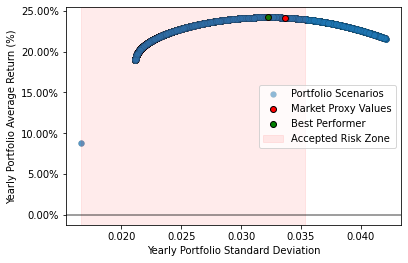

In [36]:
#Visual Representation
trade_days_per_year = 252
risk_gap = np.array(risk_gap)*trade_days_per_year
best_portfolio[0] = np.array(best_portfolio[0])*trade_days_per_year
x = np.array(risk_vector)
y = np.array(return_vector)*trade_days_per_year

fig, ax = plt.subplots()
ax.scatter(x, y, alpha=0.5, 
           linewidths=0.1,  
           edgecolors='black', 
           label='Portfolio Scenarios'
            )

ax.scatter(x[0], 
           y[0], 
           color='red', 
           linewidths=1,  
           edgecolors='black', 
           label='Market Proxy Values')
 
ax.scatter(best_portfolio[1], 
            best_portfolio[0], 
            color='green', 
            linewidths=1,  
            edgecolors='black', 
            label='Best Performer')

ax.axvspan(min_risk,
           max_risk, 
           color='red', 
           alpha=0.08,
           label='Accepted Risk Zone')

ax.set_ylabel("Yearly Portfolio Average Return (%)")
ax.set_xlabel("Yearly Portfolio Standard Deviation")

ax.axhline(y=0, color='black',alpha=0.5)

ax = plt.gca()
ax.legend(loc=0)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])


Finally we could find the actual percentage of Tesla and Apple stocks in this portfolio. (Note that the method would be the same for more number of stocks!)

In [37]:
import pandas as pd
#Output Table of Distributions
portfolio_loc = np.where((portfolio_array[:,0]==(best_portfolio[0]/trade_days_per_year))&(portfolio_array[:,1]==(best_portfolio[1])))[0][0]
best_distribution = distrib_vector[portfolio_loc][0].tolist()
d = {"Stock Name": portfolio_, "Stock % in Portfolio": best_distribution}
output = pd.DataFrame(d)
output = output.sort_values(by=["Stock % in Portfolio"],ascending=False)
output= output.style.format({"Stock % in Portfolio": "{:.2%}"})
output

,Stock Name,Stock % in Portfolio
1,TSLA,70.54%
0,AAPL,29.46%
